In [143]:
def example_downforce_curve(speed, coef_low_speed=1, coef_medium_speed=1, coef_high_speed=1):
    a = (coef_high_speed * 0.09)
    b = (coef_medium_speed * 2.5)
    c = (coef_low_speed * 5)
    return max(0, a * speed * speed + b * speed + c)

def example_drag_curve(speed):
    a = 0.08
    b = 2
    c = 0
    return max(0, a * speed * speed + b * speed + c)


class Front_wing:
    def __init__(self, downforce_curve, drag_curve):
        self.downforce_curve = downforce_curve
        self.drag_curve = drag_curve
    
    def downforce(self, speed):
        return self.downforce_curve(speed)

    def drag(self, speed):
        return self.drag_curve(speed)
    
f_w = Front_wing(example_downforce_curve, example_drag_curve)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Aeorynamic curves'}, xlabel='Speed (km/h)', ylabel='Forces (Nm)'>)

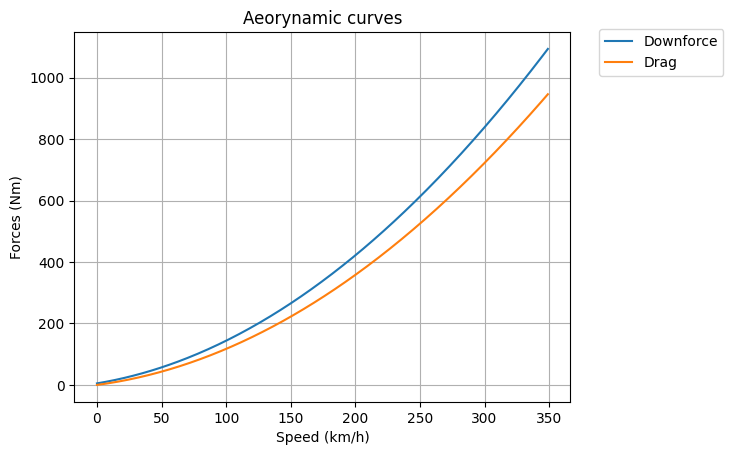

In [144]:
def plot_downforce_curve(wing):
    import numpy as np
    import matplotlib.pyplot as plt
    from sim_core.utils import kph_to_ms

    speeds = np.arange(0, 350)
    downforce_values = [wing.downforce(kph_to_ms(speed)) for speed in speeds]
    drag_values = [wing.drag(kph_to_ms(speed)) for speed in speeds]

    fig, ax = plt.subplots()
    ax.plot(speeds, downforce_values, label="Downforce")
    ax.plot(speeds, drag_values, label="Drag")
    ax.grid()
    ax.set_title('Aeorynamic curves')
    ax.set_xlabel('Speed (km/h)')
    ax.set_ylabel('Forces (Nm)')
    fig.legend(bbox_to_anchor=(1.15, 0.9))
    return fig, ax

plot_downforce_curve(f_w)

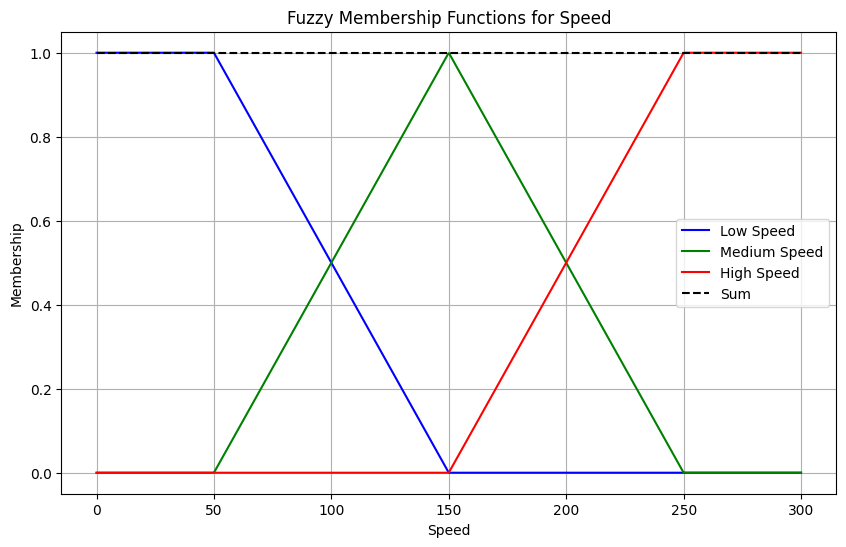

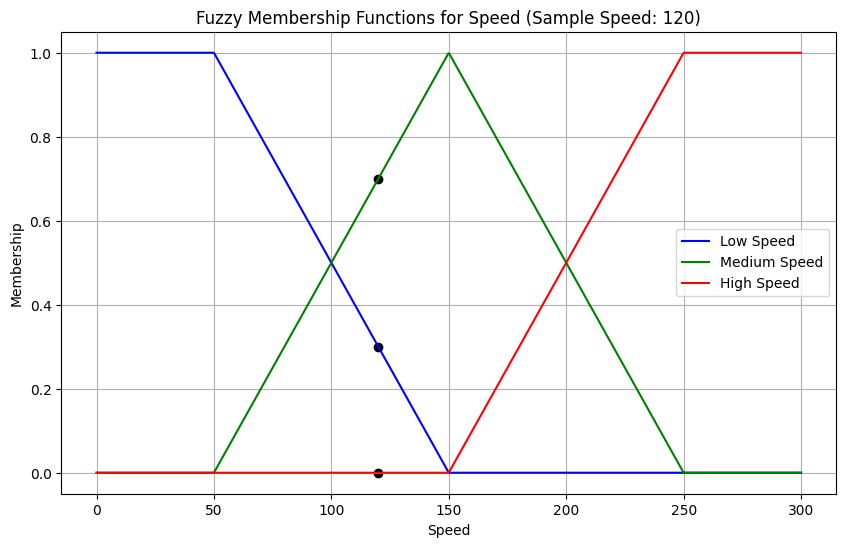

(0.30000000000000004, 0.7, 0)

In [145]:
import matplotlib.pyplot as plt
import numpy as np

def low_speed(x):
    if x <= 50:
        return 1
    elif 50 < x < 150:
        return 1 - (x - 50) / 100
    else:
        return 0

def medium_speed(x):
    if 50 < x < 150:
        return (x - 50) / 100
    elif 150 <= x < 250:
        return 1 - (x - 150) / 100
    else:
        return 0

def high_speed(x):
    if x <= 150:
        return 0
    elif 150 < x < 250:
        return (x - 150) / 100
    else:
        return 1

def speed_membership(speed):
    """
    Returns the membership values for a given speed in the three sets: Low, Medium, and High.
    """
    return low_speed(speed), medium_speed(speed), high_speed(speed)

# Test functions
x_values = np.linspace(0, 300, 1000)
low_values = [low_speed(x) for x in x_values]
medium_values = [medium_speed(x) for x in x_values]
high_values = [high_speed(x) for x in x_values]

sum_values = np.array(low_values) + np.array(medium_values) + np.array(high_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, low_values, label='Low Speed', color='blue')
plt.plot(x_values, medium_values, label='Medium Speed', color='green')
plt.plot(x_values, high_values, label='High Speed', color='red')
plt.plot(x_values, sum_values, label='Sum', color='black', linestyle='--')
plt.title('Fuzzy Membership Functions for Speed')
plt.xlabel('Speed')
plt.ylabel('Membership')
plt.legend()
plt.grid(True)
plt.show()

# Test with a sample speed
sample_speed = 120
low_membership, medium_membership, high_membership = speed_membership(sample_speed)

# Plot the membership functions along with the sample speed membership
plt.figure(figsize=(10, 6))
plt.plot(x_values, low_values, label='Low Speed', color='blue')
plt.plot(x_values, medium_values, label='Medium Speed', color='green')
plt.plot(x_values, high_values, label='High Speed', color='red')
plt.scatter([sample_speed, sample_speed, sample_speed], [low_membership, medium_membership, high_membership], color='black', marker='o')
plt.title(f'Fuzzy Membership Functions for Speed (Sample Speed: {sample_speed})')
plt.xlabel('Speed')
plt.ylabel('Membership')
plt.legend()
plt.grid(True)
plt.show()

(low_membership, medium_membership, high_membership)

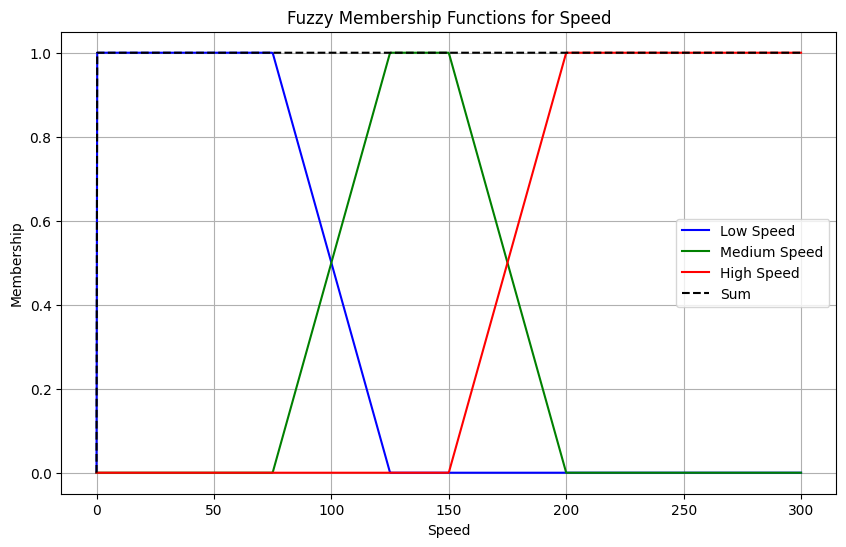

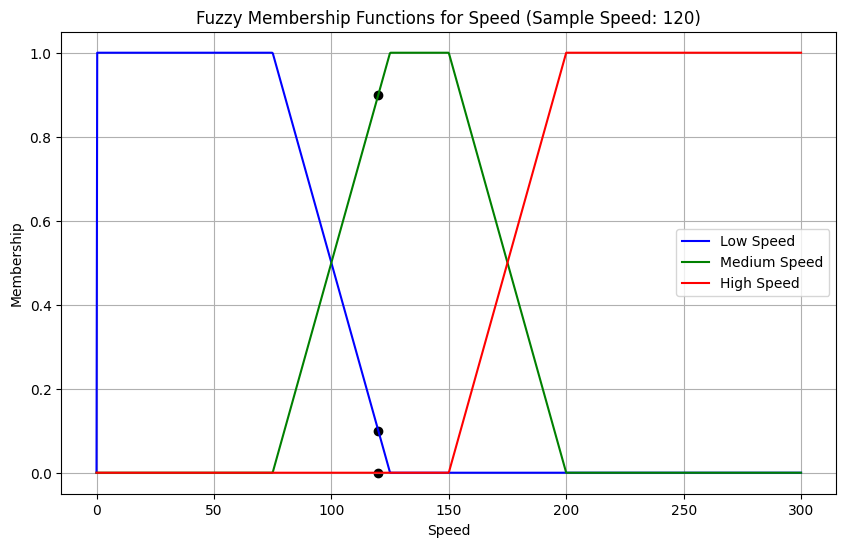

(0.1, 0.9, 0)

In [146]:
def trapezoidal_membership(speed, start, rise_start, fall_start, end):
    """
    Calculates the membership value of a speed using a trapezoidal membership function.
    
    Parameters:
    - speed: The speed for which to calculate the membership value.
    - start: The start of the trapezoid where the membership is 0.
    - rise_start: The point at which the membership starts rising to 1.
    - fall_start: The point at which the membership starts falling from 1.
    - end: The end of the trapezoid where the membership is 0.
    
    Returns:
    - The membership value of the speed.
    """
    if speed <= start or speed >= end:
        return 0
    elif start < speed <= rise_start:
        return (speed - start) / (rise_start - start)
    elif rise_start < speed < fall_start:
        return 1
    elif fall_start <= speed < end:
        return (end - speed) / (end - fall_start)
    else:
        return 0

# Define membership functions for different speed categories
def low_speed(speed):
    return trapezoidal_membership(speed, 0, 0, 75, 125)

def medium_speed(speed):
    return trapezoidal_membership(speed, 75, 125, 150, 200)

def high_speed(speed):
    return trapezoidal_membership(speed, 150, 200, 500, 500)


def speed_membership(speed):
    """
    Returns the membership values for a given speed in the three sets: Low, Medium, and High.
    """
    return low_speed(speed), medium_speed(speed), high_speed(speed)

# Test functions
x_values = np.linspace(0, 300, 1000)
low_values = [low_speed(x) for x in x_values]
medium_values = [medium_speed(x) for x in x_values]
high_values = [high_speed(x) for x in x_values]

sum_values = np.array(low_values) + np.array(medium_values) + np.array(high_values)

plt.figure(figsize=(10, 6))
plt.plot(x_values, low_values, label='Low Speed', color='blue')
plt.plot(x_values, medium_values, label='Medium Speed', color='green')
plt.plot(x_values, high_values, label='High Speed', color='red')
plt.plot(x_values, sum_values, label='Sum', color='black', linestyle='--')
plt.title('Fuzzy Membership Functions for Speed')
plt.xlabel('Speed')
plt.ylabel('Membership')
plt.legend()
plt.grid(True)
plt.show()

# Test with a sample speed
sample_speed = 120
low_membership, medium_membership, high_membership = speed_membership(sample_speed)

# Plot the membership functions along with the sample speed membership
plt.figure(figsize=(10, 6))
plt.plot(x_values, low_values, label='Low Speed', color='blue')
plt.plot(x_values, medium_values, label='Medium Speed', color='green')
plt.plot(x_values, high_values, label='High Speed', color='red')
plt.scatter([sample_speed, sample_speed, sample_speed], [low_membership, medium_membership, high_membership], color='black', marker='o')
plt.title(f'Fuzzy Membership Functions for Speed (Sample Speed: {sample_speed})')
plt.xlabel('Speed')
plt.ylabel('Membership')
plt.legend()
plt.grid(True)
plt.show()

(low_membership, medium_membership, high_membership)

In [147]:
class FrontWing:
    class Mainplane:
        def __init__(self, baseline, coef_low_speed, coef_medium_speed, coef_high_speed):
            self.baseline = baseline
            self.coef_low_speed = coef_low_speed
            self.coef_medium_speed = coef_medium_speed
            self.coef_high_speed = coef_high_speed
        def downforce(self, speed):
            from sim_core.utils import kph_to_ms
            low_membership, medium_membership, high_membership = speed_membership(speed)
            #print("low ", low_membership, " med ", medium_membership, " high ", high_membership)
            df = self.baseline(kph_to_ms(speed))
            return df * self.coef_low_speed * low_membership + df * self.coef_medium_speed * medium_membership + df * self.coef_high_speed * high_membership

    def __init__(self, mainplane):
        self.mainplane = mainplane
    def downforce(self, speed):
        return self.mainplane.downforce(speed)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Aeorynamic curves'}, xlabel='Speed (km/h)', ylabel='Forces (Nm)'>)

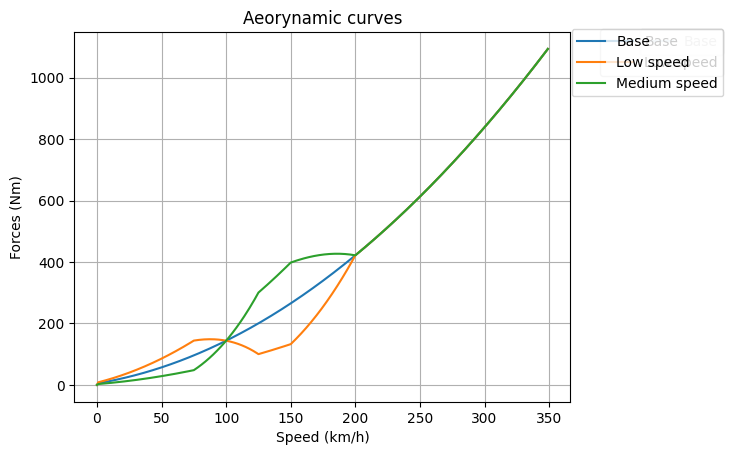

In [148]:
f_w = FrontWing(FrontWing.Mainplane(example_downforce_curve, 1, 1, 1))
f_w2 = FrontWing(FrontWing.Mainplane(example_downforce_curve, 1.5 ,0.5, 1))
f_w3 = FrontWing(FrontWing.Mainplane(example_downforce_curve, 0.5, 1.5, 1))

def plot_downforce_curve(wing, fig_ax=None, label=None):
    import numpy as np
    import matplotlib.pyplot as plt
    from sim_core.utils import kph_to_ms

    speeds = np.arange(0, 350)
    downforce_values = [wing.downforce(speed) for speed in speeds]

    if fig_ax == None:
        fig, ax = plt.subplots()
    else:
        fig, ax = fig_ax
    if label is None:
        label = "Downforce"
    ax.plot(speeds, downforce_values, label=label)
    ax.grid()
    ax.set_title('Aeorynamic curves')
    ax.set_xlabel('Speed (km/h)')
    ax.set_ylabel('Forces (Nm)')
    fig.legend(bbox_to_anchor=(1.15, 0.9))
    return fig, ax

fig, ax = plot_downforce_curve(f_w, label="Base")
fig, ax = plot_downforce_curve(f_w2, (fig, ax), label="Low speed")
plot_downforce_curve(f_w3, (fig, ax), label="Medium speed")